In [5]:
import os
import dotenv

dotenv.load_dotenv()

True

In [6]:
from langchain_openai import OpenAI
# llm = OpenAI()
# llm.invoke("What is the capital of France?")

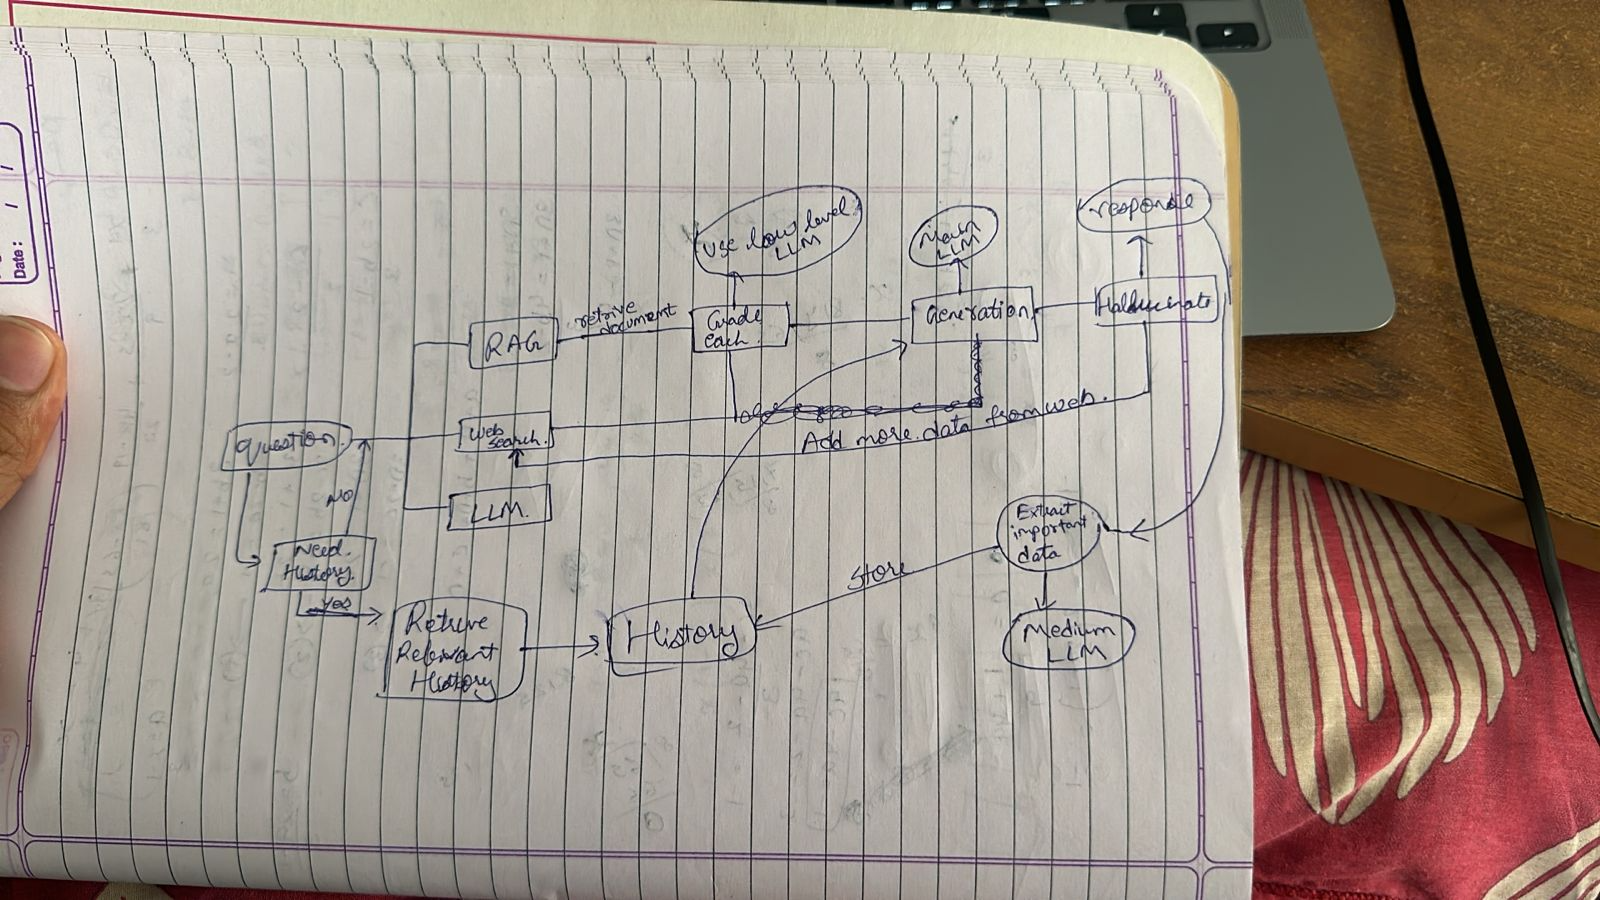

# Pinecone Database

In [63]:
from pinecone import Pinecone, ServerlessSpec, PodSpec  
import time  
# configure client  
pinecone_api_key = os.getenv('PINECONE_API_KEY')
pc = Pinecone(api_key=pinecone_api_key) 

use_serverless = True
if use_serverless:  
    spec = ServerlessSpec(cloud='aws', region='us-east-1')  
else:  
    # if not using a starter index, you should specify a pod_type too  
    spec = PodSpec()  
# check for and delete index if already exists  
index_name = 'pycone2'  
if index_name in pc.list_indexes().names():  
    pc.delete_index(index_name)  
# create a new index  
pc.create_index(  
    index_name,  
    dimension=1536,  # dimensionality of text-embedding-ada-002  
    metric='cosine',  
    spec=spec  
)  
# wait for index to be initialized  
while not pc.describe_index(index_name).status['ready']:  
    time.sleep(1)

# Setting up Vector Store

In [73]:
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader

pdf_name = "documents/research.pdf"
loader = PyPDFLoader(pdf_name, extract_images=True)
pages = loader.load()


In [74]:
pages

[Document(metadata={'source': 'documents/research.pdf', 'page': 0}, page_content='Backprop-Free Reinforcement Learning with Active Neural Generative Coding\nAlexander G. Ororbia1, Ankur Mali2\n1Rochester Institute of Technology\n2The Pennsylvania State University\nago@cs.rit.edu, aam35@psu.edu\nAbstract\nIn humans, perceptual awareness facilitates the fast recogni-\ntion and extraction of information from sensory input. This\nawareness largely depends on how the human agent interacts\nwith the environment. In this work, we propose active neural\ngenerative coding, a computational framework for learning\naction-driven generative models without backpropagation of\nerrors (backprop) in dynamic environments. Speciﬁcally, we\ndevelop an intelligent agent that operates even with sparse re-\nwards, drawing inspiration from the cognitive theory of plan-\nning as inference. We demonstrate on several simple control\nproblems that our framework performs competitively with\ndeep Q-learning. The ro

In [88]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=700,
    chunk_overlap=20,
    length_function=len,
)
docs = splitter.split_documents(pages)

In [95]:
docs

[Document(metadata={'source': 'documents/research.pdf', 'page': 0}, page_content='Backprop-Free Reinforcement Learning with Active Neural Generative Coding\nAlexander G. Ororbia1, Ankur Mali2\n1Rochester Institute of Technology\n2The Pennsylvania State University\nago@cs.rit.edu, aam35@psu.edu\nAbstract\nIn humans, perceptual awareness facilitates the fast recogni-\ntion and extraction of information from sensory input. This\nawareness largely depends on how the human agent interacts\nwith the environment. In this work, we propose active neural\ngenerative coding, a computational framework for learning\naction-driven generative models without backpropagation of\nerrors (backprop) in dynamic environments. Speciﬁcally, we\ndevelop an intelligent agent that operates even with sparse re-'),
 Document(metadata={'source': 'documents/research.pdf', 'page': 0}, page_content='wards, drawing inspiration from the cognitive theory of plan-\nning as inference. We demonstrate on several simple contr

In [84]:
# from langchain_ai21 import AI21SemanticTextSplitter

# semantic_text_splitter = AI21SemanticTextSplitter(
#     chunk_size=1500,
#     chunk_overlap=20,
# )
# docs = semantic_text_splitter.split_documents(pages)


In [96]:
len(docs)

71

In [18]:
# text_splitter = CharacterTextSplitter(chunk_size=2000, chunk_overlap=20)
# docs = text_splitter.split_documents(pages)
# docs

In [27]:
from langchain_pinecone import PineconeVectorStore  
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone


pinecone_api_key = os.getenv('PINECONE_API_KEY')
pc = Pinecone(api_key=pinecone_api_key) 

index_name = "pycone2"
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
pdf_name = "documents/research.pdf"


# To add documents to the Vector DB.
# docsearch = PineconeVectorStore.from_documents(docs, embeddings, index_name=index_name, namespace=pdf_name)
docsearch = PineconeVectorStore(index_name=index_name, embedding=embeddings, namespace=pdf_name)

In [29]:
retriever = docsearch.as_retriever(
        search_type="mmr",
        search_kwargs={'k': 10}
    )
retriever.invoke("what is the abstract of the document?")

[Document(page_content='imizes the discounted long-term future reward). Formally,\n31', metadata={'page': 2.0, 'source': 'documents/research.pdf'}),
 Document(page_content='arXiv:1810.12894.\nClark, A. 2015. Surﬁng uncertainty: Prediction, action, and\nthe embodied mind. Oxford University Press.\nFriston, K. 2005. A theory of cortical responses. Philosophi-\ncal transactions of the Royal Society B: Biological sciences ,\n360(1456): 815–836.\nFriston, K. 2009. The free-energy principle: a rough guide\nto the brain? Trends in cognitive sciences, 13(7): 293–301.\nFriston, K.; FitzGerald, T.; Rigoli, F.; Schwartenbeck, P.;\nand Pezzulo, G. 2017a. Active inference: a process theory.\nNeural computation, 29(1): 1–49.\nFriston, K.; Mattout, J.; and Kilner, J. 2011. Action un-\nderstanding and active inference. Biological cybernetics,\n104(1): 137–160.', metadata={'page': 7.0, 'source': 'documents/research.pdf'}),
 Document(page_content='NGC (ANGC). ANGC is built on the premise that an agent\n

# Summarize the Document

In [56]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate

summay_documents = retriever.invoke("Summarize the main points of the document.")

retrieved_text = '\n'.join([y.page_content for y in summay_documents])

# LLM
llm_summary = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.5)

# Prompt
prompt_summary = lambda x : ChatPromptTemplate.from_messages(
    [
        HumanMessage(
            f'''You are an expert in summarization. 
                Using the retrieved content, provide a concise summary of the document from a bird's eye view in 1-2 sentences, highlighting the main points.\n\n
                Retrieved Content: {x['retrieved_text']}
            '''
        )
    ]
)

# Chain
summarization_chain = prompt_summary | llm_summary | StrOutputParser()
summarization = summarization_chain.invoke({"retrieved_text": retrieved_text})

In [57]:
summarization

'The document discusses the Active Neural Generative Coding (ANGC) framework for control problems, highlighting its compatibility with common reinforcement learning heuristics and the potential for further improvement. The framework aims to encourage efficient environmental exploration and outperforms other models in solving control problems, showcasing its value in designing agents.'

## Question Router

In [80]:
from typing import Literal

from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource or just answer using Large Language Model (llm)."""

    datasources: Literal["vector_store", "web_search", "llm"] = Field(
        ...,
        description="Given a user question choose which datasources would be most relevant or Large Language Model (llm) for answering their question",
    )


llm_router = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm = llm_router.with_structured_output(RouteQuery)
preamble_router = f"""You are a master at finding information! You have three knowledge sources:

    1. A massive document storage system containing detailed summaries (vectorstore).
    summary for the document is: {summarization}
    2. Web search for real-time data.
    3. LLM for general knowledge and language tasks.

    When a user asks a question, if it directly relates to a document description in the storage system, use vectorstore to answer their question. 
    If the question requires real-time information, use web search. For general knowledge or language-related tasks, use LLM to provide the best answer."""
prompt_route = ChatPromptTemplate.from_messages(
    [
        ("system", preamble_router),
        ("human", "{question}"),
    ]
)

router = prompt_route | structured_llm
response = router.invoke({"question": "What is the today's weather update?"})
response1 = router.invoke({"question": "What is ANGC?"})
response2 = router.invoke({"question": "Hi how are you?"})

In [87]:
print(response.datasources)
print(response1)
print(response2)

web_search
datasources='vector_store'
datasources='llm'


## Generater LLM
This simply generates answer based on the question given to it.

In [124]:
question = "Who wrote Backprop-Free Reinforcement Learning with Active Neural Generative Coding?"
documents = retriever.invoke(question)
retrieved_text = '\n'.join([y.page_content for y in documents])

In [62]:
### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage


# Preamble
preamble_rag = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

# LLM
llm_rag = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Prompt
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", preamble_rag),
        ("human", "Question : {question}\nRetrieved Content : {documents}")
    ]
)

# Chain
rag_chain = prompt | llm_rag | StrOutputParser()

# Generate
# answer = rag_chain.invoke({"question": question, "documents": retrieved_text})

In [126]:
# answer

'Alexander G. Ororbia and Ankur Mali wrote "Backprop-Free Reinforcement Learning with Active Neural Generative Coding."'

## LLM fallback
When question is just a basic conversation than this is used.

In [63]:
### LLM fallback

from langchain_core.output_parsers import StrOutputParser


# Preamble
preamble_original = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. Use three sentences maximum and keep the answer concise."""

# LLM
llm_original = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Prompt
prompt = lambda x: ChatPromptTemplate.from_messages(
    [
        ("system", preamble_original),
        ("human", f"Question: {x['question']}")
    ]
)

# Chain
llm_chain = prompt | llm_original | StrOutputParser()

# Run
# question = "Hiie, How are you buddy."
# llm_chain.invoke({"question": question})

In [65]:
# llm_chain

## Web Search Tool

In [66]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults()

In [129]:
# web_search_tool.invoke("What is todays wethear in Ahmedabad?")

[{'url': 'https://www.skymetweather.com/content/weather-news-and-analysis/chennai-records-first-40-degree-of-season-pre-monsoon-showers-next-week/',
  'content': 'Image Credit: www.agriculture.com Other Latest Stories May 3, 2024 May 3, 2024 May 3, 2024 May 3, 2024 May 3, 2024 May 3, 2024 May 2, 2024 May 2, 2024 May 2, 2024 May 2, 2024 May 2, 2024 May 2, 2024 latest news USAID Skymet Partnership Download the Skymet App Subscribe to our mailing list to get the our Newsletter Premium Weather Services Rain and thundershowers are expected over the city and suburbs between the 06th\xa0and 10th of May. Exercise caution for some lightning strikes and gusty winds, more so, for the northern parts and interiors of the state.  The intensity and the spread could be large on 07th\xa0and 08th May.  Also, a southerly stream of winds from the southwest Bay of Bengal, all along the coastline will feed plenty of moisture.'},
 {'url': 'https://www.pratidintime.com/latest-assam-news-breaking-news-assam/in

## Retrieval Grader
Grades every document which is relevant or not based on the question for the input of LLM to answer the question.

In [45]:
question = "What is the capital of France?"
docs = web_search_tool.invoke(question)
# retrieved_text = docs[0]
docs

[{'url': 'https://en.wikipedia.org/wiki/Paris',
  'content': 'The city\'s population loss came to a temporary halt at the beginning of the 21st century; the population increased from 2,125,246 in 1999 to 2,240,621 in 2012, before declining again slightly in 2017, 2018, and again in 2021.[159][160]\nParis is the core of a built-up area that extends well beyond its limits: commonly referred to as the agglomération Parisienne, and statistically as a unité urbaine (a measure of urban area), the Paris agglomeration\'s population of 10,785,092 in 2017[161] made it the largest urban area in the European Union.[162] City-influenced commuter activity reaches well beyond even this in a statistical aire d\'attraction de Paris ("functional area", a statistical method comparable to a metropolitan area[163]), that had a population of 13,024,518 in 2017,[164] 19.6% of the population of France,[165] and the largest metropolitan area in the Eurozone.[162]\nAccording to Eurostat, the EU statistical agen

In [67]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: Literal["yes", "no"] = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# Prompt
preamble_retrieval = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# LLM with function call
llm_retrieval = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm_retrieval.with_structured_output(GradeDocuments)

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", preamble_retrieval),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question} \n\n Is the document relevant to the user question?"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
# retrieval_grader.invoke({"document": docs[0]['content'], "question": question})

## Answer Grader
This is the Final check of the answer wether the generated answer serves the asked question of not.

In [111]:
question = "Give 3 useful tips for a healthy lifestyle."
llm_test = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
test = llm_test.invoke(question)

In [113]:
test.content

'1. Eat a balanced diet: Include a variety of fruits, vegetables, whole grains, lean proteins, and healthy fats in your meals to ensure you are getting all the necessary nutrients for optimal health.\n\n2. Stay active: Aim for at least 30 minutes of moderate exercise most days of the week. This can include activities such as walking, jogging, swimming, or yoga. Regular physical activity can help improve your mood, boost your energy levels, and reduce your risk of chronic diseases.\n\n3. Get enough sleep: Aim for 7-9 hours of quality sleep each night to allow your body to rest and recharge. Poor sleep can negatively impact your mood, cognitive function, and overall health. Establishing a bedtime routine and creating a comfortable sleep environment can help improve your sleep quality.'

In [114]:
### Answer Grader
from typing import Literal

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: Literal["yes", "no"] = Field(
        ...,
        description="Binary score to assess whether the answer accurately addresses the question and provides a satisfactory resolution. Use 'yes' if the answer is relevant and provides a satisfactory resolution, and 'no' if the answer does not address the question or does not provide a satisfactory resolution."
    )

# Preamble
preamble_ans_g = """You are a grader assessing whether an answer addresses or resolves a question. 
Give a binary score of 'yes' or 'no'. 'yes' means that the answer accurately addresses the question and provides a satisfactory resolution."""

# LLM with function call
llm_ans_g = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm_ans_g.with_structured_output(GradeAnswer)

# Prompt
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", preamble_ans_g),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
# res = answer_grader.invoke({"question": question,"generation": test.content})

In [115]:
res

GradeAnswer(binary_score='yes')

# Extract useful information from conversation
Structured output

In [71]:
from typing import List, Optional

from langchain_core.pydantic_v1 import BaseModel, Field


class History(BaseModel):
    """Key-Information pair about the conversation."""

    # ^ Doc-string for the entity Person.
    # This doc-string is sent to the LLM as the description of the schema Person,
    # and it can help to improve extraction results.

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    key: Optional[str] = Field(default=None, description="The name of one of the Key Information in conversation")
    value: Optional[str] = Field(
        default=None, description="The information related to that particular Key in full sentence"
    )


class Data(BaseModel):
    """Extracted data about the Conversation."""

    # Creates a model so that we can extract multiple entities.
    info: List[History]

In [72]:
from typing import Optional

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Define a custom prompt to provide instructions and any additional context.
# 1) You can add examples into the prompt template to improve extraction quality
# 2) Introduce additional parameters to take context into account (e.g., include metadata
#    about the document from which the text was extracted.)
prompt_history = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert extraction algorithm. "
            "Only extract relevant information from Human-AI Conversation in pair of Key-Value(Information). "
            "Remeber to give value in full sentence rather than just a word."
            "Key should be presice to the information and should be descriptive as well."
            "If you do not think any information to be relevent in future, "
            "return null."
        ),
        # Please see the how-to about improving performance with
        # reference examples.
        # MessagesPlaceholder('examples'),
        ("human", "{question}"),
        ("ai", "{answer}"),
    ]
)

In [73]:
# question = "My name is Tirth remember this."
# llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
# answer = llm.invoke(question)
# print(answer)


llm_history = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
runnable = prompt_history | llm_history.with_structured_output(schema=Data)
# res = runnable.invoke({"question": question, "answer": answer})
# res

# Do we need History or not Grader

In [12]:
question1 = "What was my name that i had told you about?"
question2 = "My name is tirth."

In [74]:
### History needed Grader
from typing import Literal
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess wheather history of previous conversation is required to answer the question."""

    binary_score: Literal["yes", "no"] = Field(...,description="History of previous conversation required to address the question, 'yes' or 'no'")

# Preamble
preamble_hist_g = """You are a grader assessing whether history of previous conversation is required to answer the question. 
Give a binary score 'yes' or 'no'. 'yes' means that history of previous conversationy is required to address the question."""

# LLM with function call
llm_hist_g = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
structured_llm_grader = llm_hist_g.with_structured_output(GradeAnswer)

# Prompt
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", preamble_hist_g),
        ("human", "User question: \n\n {question}"),
    ]
)

history_grader = answer_prompt | structured_llm_grader
# res1 = history_grader.invoke({"question": question1})
# res2 = history_grader.invoke({"question": question2})
# print(res1)
# print(res2)

In [16]:
# res1.binary_score

'yes'

# History Storage and Retriver

In [1]:
history = []

# Graph

Capture the flow in as a graph.

## Graph state

In [75]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """|
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        history: list of chat history
    """
    question : str
    generation : str
    history_flag: bool
    documents : List[str]

## Graph Flow

In [116]:
from langchain.schema import Document

def history_needed(state):
    """
    Determines whether the history of previous conversation is needed to answer the question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---HISTORY NEEDED---")
    question = state["question"]
    history_flag = history_grader.invoke({"question": question}).binary_score
    if history_flag == "yes":
        print("---DECISION: HISTORY NEEDED---")
        return {"history_flag": True}
    else:
        print("---DECISION: HISTORY NOT NEEDED---")
        return {"history_flag": False}

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents}

def llm_fallback(state):
    """
    Generate answer using the LLM w/o vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---LLM Fallback---")
    question = state["question"]
    print("question",question)
    generation = llm_chain.invoke({"question": question})
    print("generation",generation)
    return {"generation": generation}

def generate(state):
    """
    Generate answer using the vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    if not isinstance(documents, list):
      documents = [documents]
    documents = '\n'.join([y.page_content for y in documents])
    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
    return {"documents": filtered_docs}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke(question)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results}

### Edges ###

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = router.invoke({"question": question})
    if source.datasources == 'web_search':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasources == 'vector_store':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    else: 
        print("---ROUTE QUESTION TO LLM---")
        return "llm_fallback"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, WEB SEARCH---")
        return "web_search"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    generation = state["generation"]


    print("---GRADE GENERATION vs QUESTION---")
    print("question",question)
    print("generation",generation)
    score = answer_grader.invoke({"question": question,"generation": generation})
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "useful"
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "not useful"











# def save_chat(state):
#     """
#     Save the chat history

#     Args:
#         state (dict): The current graph state

#     Returns:
#         str: Decision for next node to call
#     """
#     global previous_history
#     print("---SAVE CHAT---")
#     question = state["question"]
#     generation = state["generation"]
#     memory.save_context({"input": question}, {"output": generation})
#     # print("previous_history",previous_history)
#     previous_history = memory.predict_new_summary(memory.chat_memory.messages, previous_history)
#     # print("previous_history",previous_history)
#     memory.clear()
#     return 


## Build Graph

In [117]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("generate", generate) # rag
workflow.add_node("llm_fallback", llm_fallback) # llm
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("history_need", history_needed) # grade documents

# Build graph
workflow.set_entry_point("history_need")
workflow.add_conditional_edges(
    "history_need",
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search": "web_search",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not useful": "web_search", # Fails to answer question: fall-back to web-search 
        "useful": END, # Successfully answers question: save chat
    },
)
workflow.add_edge("llm_fallback", END)

# Compile
app = workflow.compile()

In [90]:
app.invoke({"question": "How Are you?"})

---HISTORY NEEDED---
---DECISION: HISTORY NOT NEEDED---
---ROUTE QUESTION---
---ROUTE QUESTION TO LLM---
---LLM Fallback---
question How Are you?
generation I'm an AI assistant, so I don't have feelings or emotions. How can I assist you today?


{'question': 'How Are you?',
 'generation': "I'm an AI assistant, so I don't have feelings or emotions. How can I assist you today?",
 'history_flag': False}

In [118]:
app.invoke({"question": "What is this given PDF about?"})

---HISTORY NEEDED---
---DECISION: HISTORY NEEDED---
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---GRADE GENERATION vs QUESTION---
question What is this given PDF about?
generation The given PDF is about the concept of Planning-as-inference (PAI), which explains goal-directed behavior as a problem of probabilistic inference using internal models to estimate action-outcome-reward sequences. It discusses an emerging theoretical framework called active inference, where biological agents learn a generative model 

{'question': 'What is this given PDF about?',
 'generation': 'The given PDF is about the concept of Planning-as-inference (PAI), which explains goal-directed behavior as a problem of probabilistic inference using internal models to estimate action-outcome-reward sequences. It discusses an emerging theoretical framework called active inference, where biological agents learn a generative model by interacting with their environment. The document also includes details about an algorithm called CC that describes how NGC processes data streams by breaking down processing into three routines.',
 'history_flag': True,
 'documents': [Document(page_content='Planning-as-inference (PAI) (Botvinick and Toussaint 2012)\nattempts to account for goal-directed behavior by casting it\nas a problem of probabilistic inference where an agent ma-\nnipulates an internal model that estimates the probability of\npotential action-outcome-reward sequences.\nOne important, emerging theoretical framework for PAI i